# Vehicle Detection Project
## Udacity Self-Driving Car Nanodegree

I this project, images taken from front-facing camera mounted on vehicles will be analyzed to detect vehicles. The process will be conducted in following orders:

Phase 1 - Training Linear SVM Classifier
1. Load training images (cars and not-cars) and examine them.
2. Define functions to extract useful featuers from training images:  
    2.1 HOG  
    2.2 spatial bin  
    2.3 color histogram  
    2.4 function to flag/extract features from images/image  
    
3. Prepare training and testing dataset  
    3.1 Use feature extraction function to extract features from images  
    3.2 Train Linear SVM Classifier   

Phase 2 - Using Sliding window to find cars
4. Define a sliding-window function to search subset of an image
5. Define Heatmap to remove false positives
6. Apply classifier to the subset of image for classification
7. Draw square around vehicles

In [1]:
import warnings
warnings.filterwarnings('ignore')

TODO: Converkt png to compatible format and see why it is notworking

## Phase 1 - Training Linear SVM Classifer

### 1. Load training images and examine them. 

Function returned a count of  8792  cars and  8968  non-cars
of size:  (64, 64, 3) and data type:  float32


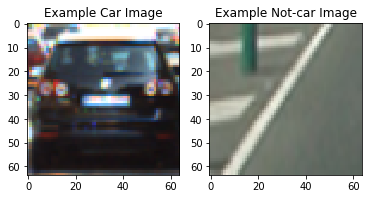

In [2]:
import glob
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

cars = []
notcars = []

# Load directories of car and not-car images
for filename in glob.iglob('./vehicles/**/*.png', recursive=True):
    cars.append(filename)
for filename in glob.iglob('./non-vehicles/**/*.png', recursive=True):
    notcars.append(filename)
    
# Define a function to return some characteristics of the dataset
def data_look(car_list, notcar_list):
    data_dict = {}
    data_dict['n_cars'] = len(car_list)
    data_dict['n_notcars'] = len(notcar_list)
    
    sample_img = mpimg.imread(car_list[0])
    data_dict['image_shape'] = sample_img.shape
    data_dict['data_type'] = sample_img.dtype
    
    return data_dict

# Pass cars and notcars 
data_info = data_look(cars, notcars)

# Report basic information of car and not-car images
print('Function returned a count of ',
         data_info['n_cars'], ' cars and ',
          data_info['n_notcars'], ' non-cars'
     )
print('of size: ', data_info['image_shape'], 
        'and data type: ', data_info['data_type']
     )

# Display a sample image from each category
rand_car_idx = np.random.randint(0, len(cars))
rand_car_img = mpimg.imread(cars[rand_car_idx])

rand_notcar_idx = np.random.randint(0, len(notcars))
rand_notcar_img = mpimg.imread(notcars[rand_notcar_idx])

fig = plt.figure()
plt.subplot(121)
plt.imshow(rand_car_img)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(rand_notcar_img)
plt.title('Example Not-car Image')

### 2. Define functions to extract useful features.

#### 2.1 HOG features

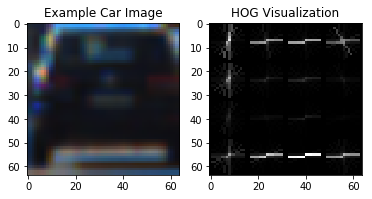

In [3]:
from skimage.feature import hog
import cv2

# generate hog feature extraction function
def get_hog_features(img, orient=11, pix_per_cell=16, 
                     cell_per_block=2, vis=False, 
                     feature_vec = True):
    if vis == True:
        # Use skimag.hog() to get both features and a visualization
        features, hog_image = hog(img, 
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    
    else:
        features = hog(img, 
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell), 
                       cells_per_block=(cell_per_block, cell_per_block), 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# choose a random image to visualise HOG feature
ind = np.random.randint(0, len(cars))
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


# Call our hog function to the sample image
features, hog_image = get_hog_features(gray, vis=True, feature_vec = False)

# Plot example
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

#### 2.2 Spatial and 2.3 Color Histogram Features

In [4]:
# spatial bin
def bin_spatial(img, size=(32,32)):
    # use cv2.resize().ravel() to create the feature vector
    spatial_features = cv2.resize(img, size).ravel()
    # return the feature vector
    return spatial_features

# color hist
def color_hist(img, nbins=32, bins_range=(0,1)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features  

print('spatial and color histogram features ')

spatial and color histogram features 


#### 2.4 function to flag/extract features from images  
This function extract features from a batch of pictures, thus is sued for extracting features for training images.

In [5]:
# This section is dedicated to making feature vectors
from sklearn.preprocessing import StandardScaler
    
def extract_features(imgs, color_space='RGB',
                     spatial_size = (32, 32),
                     hist_bins = 32, hist_range = (0, 1),
                     orient = 11, pix_per_cell = 16, cell_per_block = 2, hog_channel = "ALL",
                     spatial_feat = True, hist_feat = False, hog_feat = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image_dir in imgs:
        image = mpimg.imread(image_dir)
        file_features = []

        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size = spatial_size)
            file_features.append(spatial_features)

        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins = hist_bins, bins_range = hist_range)
            file_features.append(hist_features)

        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features = np.append(hog_features, get_hog_features(feature_image[:,:,channel]))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                                orient, pix_per_cell, cell_per_block,
                                                vis=False, feature_vec=True)
            file_features.append(hog_features)

        # Append the new feature vectors to the feature list
        features.append(np.concatenate(file_features))
        # Return list of feature vectors

    return features

print('feature extraction function loaded successfully!')

feature extraction function loaded successfully!


### 3. Prepare Testing Images

#### 3.1 Use feature extraction function to extract features from images.

In [6]:
car_features = extract_features(cars)
notcar_features = extract_features(notcars)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Training SVC with training images

# Build a stack of labels with 1 being cars and 0 being not-cars
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#### 3.2 Train Linear Model

In [7]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn import svm

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.25, random_state = rand_state)
svc = svm.SVC(C=10, kernel='rbf')
svc.fit(X_train, y_train)

print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

Test Accuracy of SVC =  0.995945945946


## Phase 2 - Using Sliding Window to Find Cars

### 1. Define a sliding-window function to search subset of an image

We will have the sizes of windows scaled depending on the proximity to the vehicle. Below, I approximated the sizes of squares that will fit our needs. 

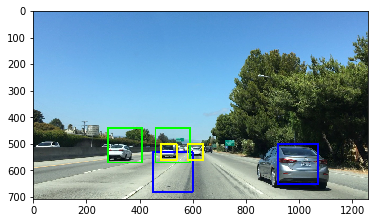

In [8]:
sample_image = mpimg.imread('bbox-example-image.jpg')
box_sample_image = np.copy(sample_image)

# Closest: window size 150px
lg_px = 150
cv2.rectangle(box_sample_image, (450,680), (450+lg_px,680-lg_px), (0, 0, 255), 5)
cv2.rectangle(box_sample_image, (920,650), (920+lg_px,650-lg_px), (0, 0, 255), 5)

# Middle: window size 100px
md_px = 100
cv2.rectangle(box_sample_image, (280,570), (410,440), (0, 255, 0), 5)
cv2.rectangle(box_sample_image, (460,570), (590,440), (0, 255, 0), 5)

# Furthest: window size 50px 
sm_px = 50
cv2.rectangle(box_sample_image, (580,560), (640,500), (255, 255, 0), 5)
cv2.rectangle(box_sample_image, (480,560), (540,500), (255, 255, 0), 5)

# Possible breakpoints: 680 - 570 large
#                       570 - 560 medium 
#                       560 - 520 small

fig = plt.figure()
plt.imshow(box_sample_image)

In [9]:
# Sliding box test
single_image = mpimg.imread('bbox-example-image.jpg')

# coordinates of windows
def slide_window(img, x_start_stop = [None, None],
                 y_start_stop = [None, None],
                 xy_window = (64, 64),
                 xy_overlap = (0.5, 0.5)
                ):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((x_span-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((y_span-ny_buffer)/ny_pix_per_step) 
    
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


Now that we have a working sliding window function, I will move onto building a pipeline of sliding window that implements the above function and returns coordinates of windows that are scaled. 

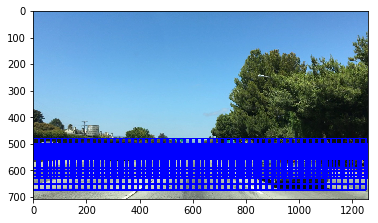

In [10]:
# Possible breakpoints: 570 - 680 large (150)
#                       570 - 560 medium (100)
#                       560 - 520 small (50)

def scaled_window(img):
    window_list = []
    large_window_list = slide_window(img, 
                 x_start_stop = [None, None],
                 y_start_stop = [480, 680],
                 xy_window = (150, 150),
                 xy_overlap = (0.85, 0.85)
                )
    window_list.extend(large_window_list)

    medium_window_list = slide_window(img, 
             x_start_stop = [None, None],
             y_start_stop = [500, 630],
             xy_window = (90, 90),
             xy_overlap = (0.85, 0.85)
            )
    window_list.extend(medium_window_list)
    
    small_window_list = slide_window(img, 
                 x_start_stop = [None, None],
                 y_start_stop = [500, 560],
                 xy_window = (50, 50),
                 xy_overlap = (0.85, 0.85)
                )
    window_list.extend(small_window_list)
    
    return window_list

sample_image = mpimg.imread('bbox-example-image.jpg')
scaled_window_list = scaled_window(sample_image)


def draw_boxes(img, bboxes, color = (0, 0, 255), thick = 6):
    # make a copy of an image
    draw_img = np.copy(img)
    # draw bounding boxes on the image using cv2.rectangle()
    for corner in bboxes: 
        cor1, cor2 = corner
        cv2.rectangle(draw_img, cor1, cor2, (0, 0, 255), 5)
        
    return draw_img

result = draw_boxes(sample_image, scaled_window_list)
plt.imshow(result)

Extract features for a single image. This will be used with the videoclip. 

In [11]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images

def single_img_features(img, color_space='RGB',
                        spatial_size = (32, 32),
                        hist_bins=32, hist_range = (0, 1),
                        orient = 11, pix_per_cell = 16, cell_per_block = 2, hog_channel = "ALL",
                        spatial_feat = True, hist_feat = False, hog_feat = True):
    # 1. Define an empty list to receive features
    img_features = []
    # 2. Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)

    # 3. Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range = hist_range)
        img_features.append(hist_features)

    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features = np.append(hog_features, get_hog_features(feature_image[:,:,channel]))
            hog_features = np.ravel(hog_features)

        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True)
        img_features.append(hog_features)

    return np.concatenate(img_features)

Search a single image

In [12]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
import warnings
warnings.filterwarnings('ignore')

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 1), orient=11, 
                    pix_per_cell=16, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=False, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))   
        # NOTE: the np.uint8 wsa giving me a trouble becasue it made all 
        # floats into ZEROS (0)
        test_img = np.divide(test_img, 255)  

        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features)).reshape(1, -1)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

sample_image = np.copy(single_image)
sample_valid_windows = search_windows(sample_image, scaled_window_list, svc, X_scaler)

print(sample_valid_windows[0:3])
print('Done!')

[((836, 480), (986, 630)), ((858, 480), (1008, 630)), ((880, 480), (1030, 630))]
Done!


### 2. Define Heatmap to remove false positives

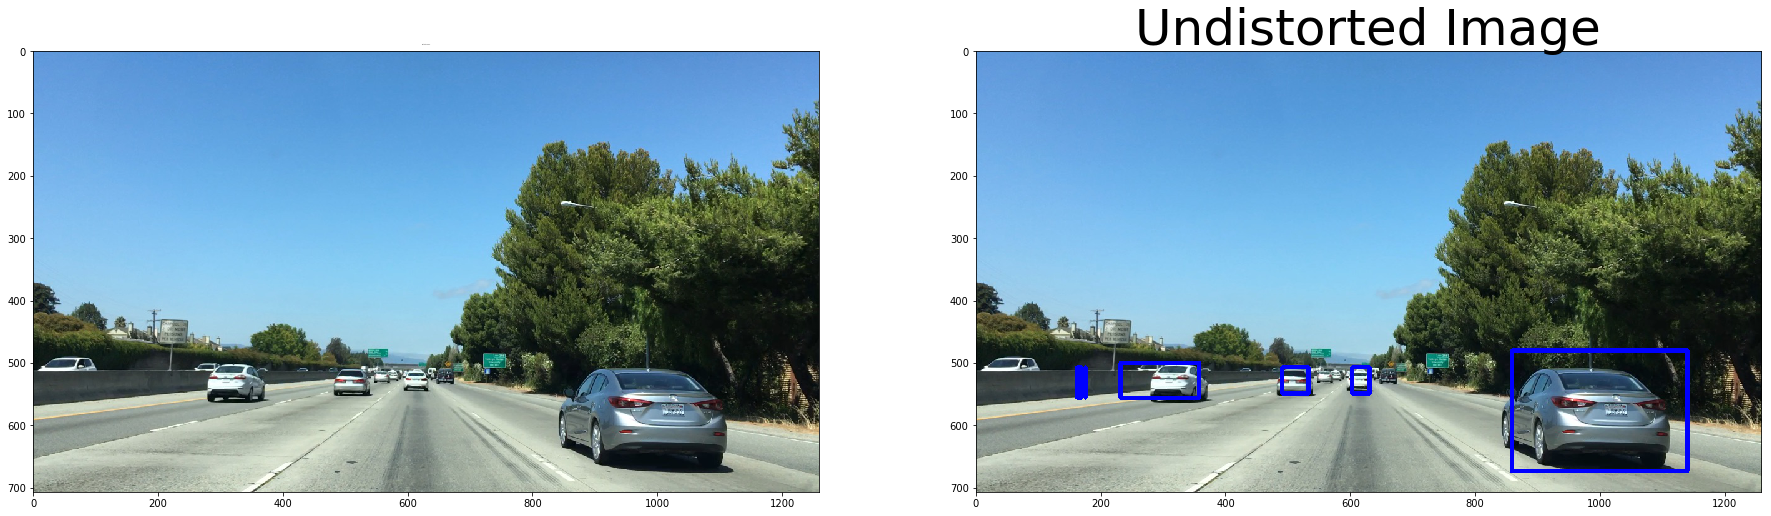

In [13]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # iterate through list of bboxes
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# Add heat to each box in box list
heat = np.zeros_like(sample_image[:,:,0]).astype(np.float64)
heat = add_heat(heat, sample_valid_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 6)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(sample_image), labels)

fig = plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
plt.subplot(121)
plt.imshow(sample_image)
plt.title('Distorted Image', fontsize = 1)
plt.subplot(122)
plt.imshow(draw_img, cmap='gist_heat')
plt.title('Undistorted Image', fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

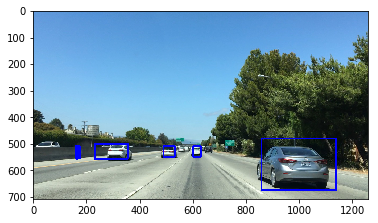

In [14]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

draw_img = draw_labeled_bboxes(np.copy(sample_image), labels)
# Display the image
fig = plt.figure()
plt.imshow(draw_img)

### 3. Apply classifier to the subset of image for classification

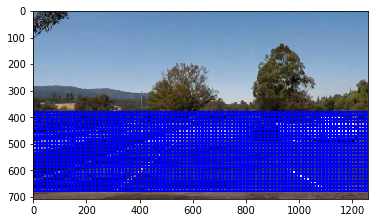

In [15]:
video_image = cv2.imread('test.png')
video_image = cv2.cvtColor(video_image, cv2.COLOR_BGR2RGB)
video_image = cv2.resize(video_image, (1259, 707))

def scaled_window_video(img):
    window_list = []
#     large_window_list = slide_window(img, 
#                  x_start_stop = [None, None],
#                  y_start_stop = [450, 680],
#                  xy_window = (150, 150),
#                  xy_overlap = (0.85, 0.85)
#                 )
#     window_list.extend(large_window_list)

    medium_window_list = slide_window(img, 
             x_start_stop = [None, None],
             y_start_stop = [380, 680],
             xy_window = (90, 90),
             xy_overlap = (0.85, 0.85)
            )
    window_list.extend(medium_window_list)
    
#     small_window_list = slide_window(img, 
#                  x_start_stop = [None, None],
#                  y_start_stop = [380, 450],
#                  xy_window = (50, 50),
#                  xy_overlap = (0.85, 0.85)
#                 )
#     window_list.extend(small_window_list)
    
    return window_list

video_windows = scaled_window_video(video_image)
result = draw_boxes(video_image, video_windows)
plt.imshow(result)

In [16]:
import collections
heat_accum = collections.deque(maxlen=5)
global heat_accum
    
    
def complete_pipeline(img):
    windows = scaled_window_video(img)
    valid_windows = search_windows(img, windows, svc, X_scaler)
    # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float64)
    heat = add_heat(heat, valid_windows)

    # Apply threshold to help remove false positive
    heat_accum.append(heat)
    heat_sum = np.zeros_like(heat_accum[0])
    for i in range(len(heat_accum)):
        heat_sum = np.add(heat_sum, heat_accum[i])
    heat_avg = np.divide(heat_sum, len(heat_accum))
    heat = apply_threshold(heat_avg, 7)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

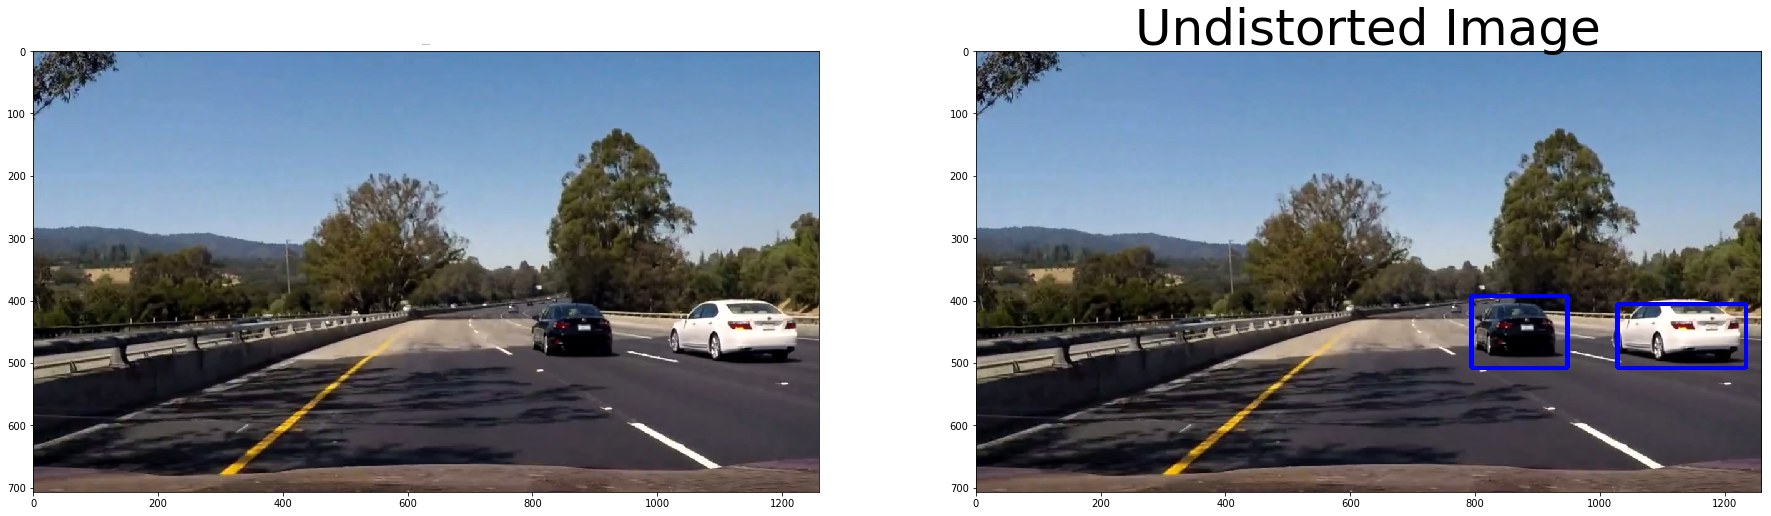

In [17]:
import warnings
warnings.filterwarnings('ignore')

video_image = cv2.imread('test.png')
video_image = cv2.cvtColor(video_image, cv2.COLOR_BGR2RGB)
video_image = cv2.resize(video_image, (1259, 707))

# fig = plt.figure()
# plt.imshow(scaled_img)

# print(np.min(video_image))
# print(video_image.shape)
out = complete_pipeline(video_image)
fig = plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
plt.subplot(121)
plt.imshow(video_image)
plt.title('Distorted Image', fontsize = 1)
plt.subplot(122)
plt.imshow(out)
plt.title('Undistorted Image', fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 4. Draw square around vehicles

In [18]:
# # Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
heat_accum = collections.deque(maxlen=15)
global heat_accum
output = './test_video_output/TestOutput.mp4'
clip2 = VideoFileClip('./project_video.mp4')
test_clip = clip2.fl_image(complete_pipeline)
%time test_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./test_video_output/TestOutput.mp4
[MoviePy] Writing video ./test_video_output/TestOutput.mp4


100%|█████████▉| 1260/1261 [7:15:14<00:19, 19.82s/it]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_output/TestOutput.mp4 

CPU times: user 7h 12min 25s, sys: 1min 19s, total: 7h 13min 44s
Wall time: 7h 15min 15s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [21]:
# Threshold was 7!!